In [74]:
import numpy as np
import pandas as pd
import cv2
import glob
import sys, os, multiprocessing

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [75]:
file_paths = glob.glob("../data/imgs/*.jpg")

In [76]:
file_paths[1]

'../data/imgs/11997_101.jpg'

In [130]:
def process_image(path):
    '''
    open an image at path:
    figure out:
    h - height
    w - width
    size - size of file
    ratio - amount of Bytes per pixel
    '''
    img = cv2.imread(path)
    
    if img is not None:
        item_dict = {}
        
        h, w = img.shape[0], img.shape[1]
        
        aspect_ratio = w / (h * 1.0)
        
        pixels = h * w
        
        st = os.stat(path)
        file_size = st.st_size
        
        b, g, r = cv2.split(img)         # get b,g,r
        
        all_r_mean = 176.00384963451177
        all_g_mean = 166.20842509882658
        all_b_mean = 158.0920543886322
        
        r_mean = np.mean(r)
        g_mean = np.mean(g)
        b_mean = np.mean(b)
        
        item_dict['h'] = h
        item_dict['w'] = w
        item_dict['aspect_ratio'] = aspect_ratio
        item_dict['pixels'] = pixels
        item_dict['file_size'] = file_size
        item_dict['r_mean'] = r_mean
        item_dict['g_mean'] = g_mean
        item_dict['b_mean'] = b_mean
        item_dict["pix_pb"] = pixels / (file_size * 1.0)
        item_dict["path"] = path
        item_dict["r_accum_err"] = np.sum((r - all_r_mean)**2)/pixels
        item_dict["g_accum_err"] = np.sum((g - all_g_mean)**2)/pixels
        item_dict["b_accum_err"] = np.sum((b - all_b_mean)**2)/pixels
        
#         temp_img = cv2.merge([r, g, b])    # switch it to rgb

        return item_dict
        
    else:
        return None

In [132]:
data = []
junk = []

start = time.time()

for idx, path in enumerate(file_paths):
    # 18.35s
    # 16.1s if not printing every read
#     if idx > 1901:
#         break
    
    result = process_image(path)
    
    if idx % 100 == 0:
        elapsed = time.time() - start
        print("time: {:4.2f}s   processing {:}/{:}\r".format(elapsed, idx, len(file_paths)), end="", flush=True)
    
    if result is not None:
        data.append(result)


In [133]:
df = pd.DataFrame(data, columns=["path", "h", "w", "pixels", "aspect_ratio", "file_size", "pix_pb", "r_mean", "g_mean", "b_mean", "r_accum_err", "g_accum_err", "b_accum_err"])

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152221 entries, 0 to 152220
Data columns (total 13 columns):
path            152221 non-null object
h               152221 non-null int64
w               152221 non-null int64
pixels          152221 non-null int64
aspect_ratio    152221 non-null float64
file_size       152221 non-null int64
pix_pb          152221 non-null float64
r_mean          152221 non-null float64
g_mean          152221 non-null float64
b_mean          152221 non-null float64
r_accum_err     152221 non-null float64
g_accum_err     152221 non-null float64
b_accum_err     152221 non-null float64
dtypes: float64(8), int64(4), object(1)
memory usage: 15.1+ MB


In [140]:
df.head()

,path,h,w,pixels,aspect_ratio,file_size,pix_pb,r_mean,g_mean,b_mean,r_accum_err,g_accum_err,b_accum_err
0,../data/imgs/28491_68.jpg,800,800,640000,1.000000,85320,7.501172,229.413972,227.713289,212.647266,0.026861,0.036141,0.053210
1,../data/imgs/11997_101.jpg,800,800,640000,1.000000,166938,3.833759,126.274078,149.567391,155.617066,0.054656,0.036767,0.035571
2,../data/imgs/68542_80.jpg,634,793,502762,1.250789,157616,3.189790,180.925826,158.143263,141.555036,0.015865,0.030551,0.031391
3,../data/imgs/79412_25.jpg,800,800,640000,1.000000,151186,4.233196,216.552556,186.867486,176.672427,0.032652,0.038144,0.046619
4,../data/imgs/25196_117.jpg,462,600,277200,1.298701,51651,5.366789,179.549928,135.804163,100.765664,0.022439,0.034735,0.061929


In [143]:
r_std = np.sqrt(np.sum(df.loc[:, "r_accum_err"].values))
g_std = np.sqrt(np.sum(df.loc[:, "g_accum_err"].values))
b_std = np.sqrt(np.sum(df.loc[:, "b_accum_err"].values))

print("red std:", r_std)
print("blue std:", g_std)
print("green std:", b_std)

red std: 75.34955215842102
blue std: 78.93761289252639
green std: 83.47397487515309


(0, 82.03117076069731)

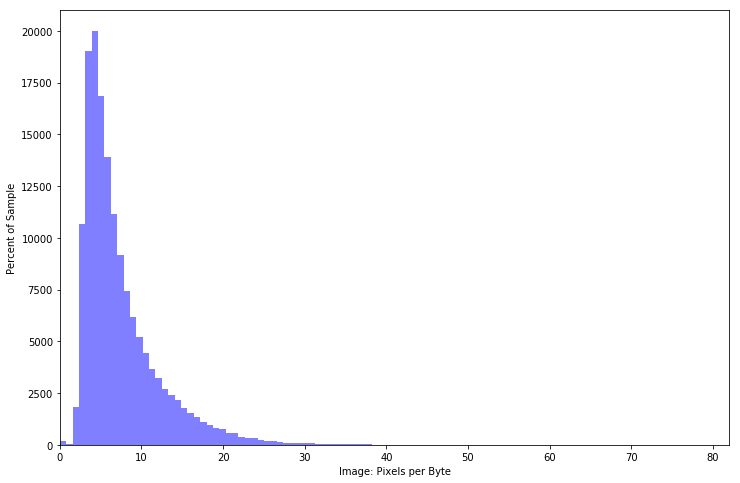

In [95]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(df.loc[:, "pix_pb"].values, bins=100, alpha=0.5, normed=False, color="blue")
ax.set_xlabel("Image: Pixels per Byte")
ax.set_ylabel("Percent of Sample")
ax.set_xlim(0)

In [103]:
_imgs = df[df.loc[:, "pix_pb"] < 1]

In [146]:
df.to_csv("../data/image_file_features.csv", sep="\t")

In [128]:
all_r_mean = df.loc[:, "r_mean"].values.mean()
print("all_r_mean:", all_r_mean)

all_g_mean = df.loc[:, "g_mean"].values.mean()
print("all_g_mean:", all_g_mean)

all_b_mean = df.loc[:, "b_mean"].values.mean()
print("all_b_mean:", all_b_mean)

all_r_mean: 176.00384963451177
all_g_mean: 166.20842509882658
all_b_mean: 158.0920543886322


(0, 267.75)

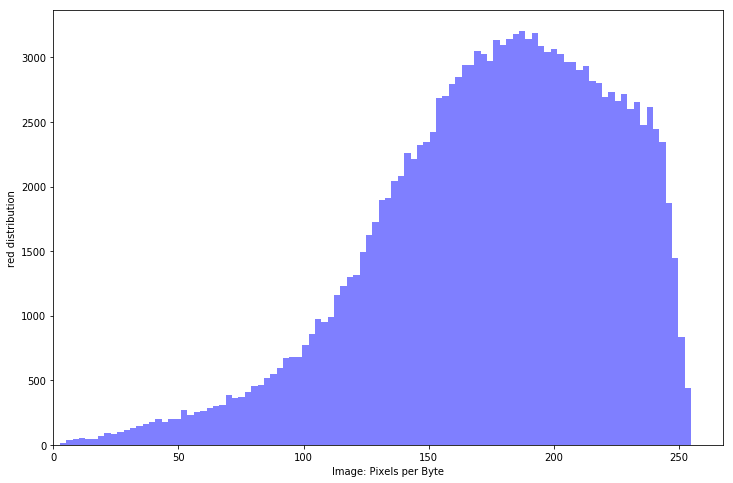

In [124]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(df.loc[:, "r_mean"].values, bins=100, alpha=0.5, normed=False, color="blue")
ax.set_xlabel("Image: Pixels per Byte")
ax.set_ylabel("red distribution")
ax.set_xlim(0)

In [118]:
small_imgs.head(20)

,path,h,w,pixels,aspect_ratio,file_size,pix_pb,r_mean,g_mean,b_mean
48,../data/imgs/16509_37.jpg,270,270,72900,1.000000,8441,8.636417,133.707119,130.390700,125.940700
100,../data/imgs/79307_115.jpg,280,280,78400,1.000000,16207,4.837416,210.216594,211.009885,210.915702
189,../data/imgs/17870_64.jpg,276,300,82800,1.086957,7173,11.543287,7.954915,8.010024,8.099722
230,../data/imgs/57486_30.jpg,298,300,89400,1.006711,29439,3.036788,133.115671,102.694306,50.993837
275,../data/imgs/8509_9.jpg,281,357,100317,1.270463,15161,6.616780,35.060498,33.835123,35.893498
334,../data/imgs/175865_42.jpg,288,288,82944,1.000000,16346,5.074269,197.280756,192.539533,192.695578
381,../data/imgs/83883_21.jpg,290,290,84100,1.000000,13653,6.159818,189.642069,189.395125,192.664578
439,../data/imgs/168679_58.jpg,260,260,67600,1.000000,13071,5.171754,229.236228,233.756583,237.408787
459,../data/imgs/174001_42.jpg,276,366,101016,1.326087,17528,5.763122,209.633464,201.879484,185.878762
610,../data/imgs/129760_18.jpg,275,606,166650,2.203636,17641,9.446743,232.221710,231.870387,230.513201


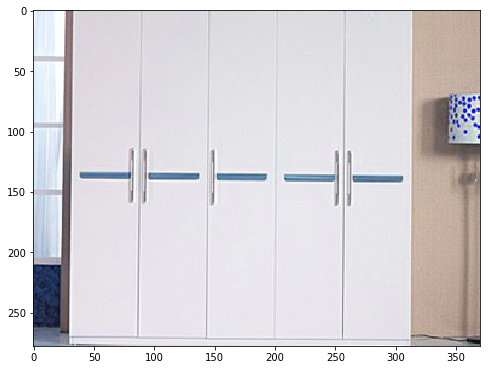

In [120]:
img = cv2.imread(small_imgs.loc[:, "path"].values[15])
fig, rx = plt.subplots(figsize=(8,8))
rx.imshow(img)